# Analysing Bike Sharing Demand

Bike sharing systems are new generation of traditional bike rentals where whole process from membership,
rental, and return has become automatic. Through these systems, user can easily rent a bike from a particular
location and return at another location.
- Today, there exists a great interest in bike sharing systems due to their important role in traffic, environmental,and health issues.
- Apart from interesting real-world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research.
- Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems.
- This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

## Problem Statement 
Over the years, a steady rise in bike rentals have been observed and bike-sharing program manager need to keep up with growing demand to efficiently cover area and introduce new station if necessary.Use provided dataset to help program manager to opptimize its efficiency to join more people to green transportation solution. 


# Dataset

The dataset contains hourly and daily records of bike sharing counts. Bike-sharing rental process is highly correlated with the environmental and seasonal settings. So, weather information is also recorded in the dataset.

In [1]:
import pandas as pd    # panda dataframe 
import seaborn as sns  # ploting package
%matplotlib inline      
from scipy.stats import f_oneway   #ANOVA analysis 
from scipy.stats import shapiro  # Normality test
import matplotlib.pyplot as plt
from scipy import stats   # Correlation analysis
import statsmodels.api as sm   # Modeling 
import statsmodels.formula.api as smf  # Modeling
import numpy as np

To explore the data, we first need to read the dataset and check each features properties:

In [2]:
df=pd.read_csv('bike_sharing.csv')

In [3]:
df.head()

,year,month,day,hour,member,weekend,season,temperature,dewpoint,humidity,windspeed,windgust,pressure,precip,precipaccum,weather,rental
0,2016,10,1,0,80,1,fall,18.33,65.0,100.0,6.0,0.0,30.1,0.0,0.0,3,103
1,2016,10,1,1,53,1,fall,17.78,64.0,100.0,10.0,0.0,30.1,0.0,0.0,3,63
2,2016,10,1,2,27,1,fall,17.78,64.0,100.0,10.0,0.0,30.1,0.0,0.0,3,33
3,2016,10,1,3,20,1,fall,17.78,64.0,100.0,10.0,0.0,30.1,0.1,0.0,3,23
4,2016,10,1,4,11,1,fall,17.78,64.0,100.0,9.0,0.0,30.1,0.0,0.0,3,11


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17466 entries, 0 to 17465
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         17466 non-null  int64  
 1   month        17466 non-null  int64  
 2   day          17466 non-null  int64  
 3   hour         17466 non-null  int64  
 4   member       17466 non-null  int64  
 5   weekend      17466 non-null  int64  
 6   season       17466 non-null  object 
 7   temperature  17466 non-null  float64
 8   dewpoint     17466 non-null  float64
 9   humidity     17466 non-null  float64
 10  windspeed    17466 non-null  float64
 11  windgust     17466 non-null  float64
 12  pressure     17466 non-null  float64
 13  precip       17466 non-null  float64
 14  precipaccum  17466 non-null  float64
 15  weather      17466 non-null  int64  
 16  rental       17466 non-null  int64  
dtypes: float64(8), int64(8), object(1)
memory usage: 2.3+ MB


### Distribution of Bike Rentals 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Bike Rental Distribution')

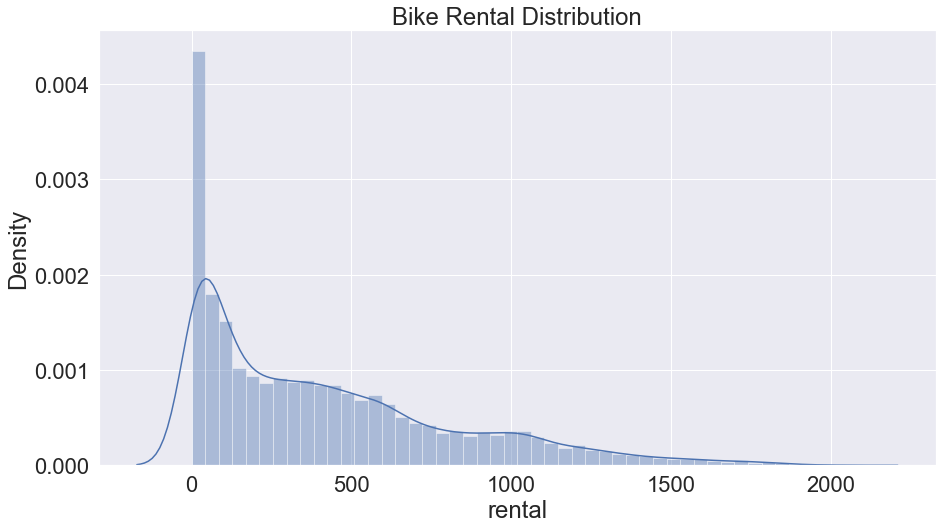

In [5]:
sns.set(rc = {'figure.figsize': (15,8)})
sns.set(font_scale = 2)

g= sns.distplot(df['rental'], color='b')
g.set_title("Bike Rental Distribution")

## 1. Does seasonliaty affect the total number of rentals? (EDA)

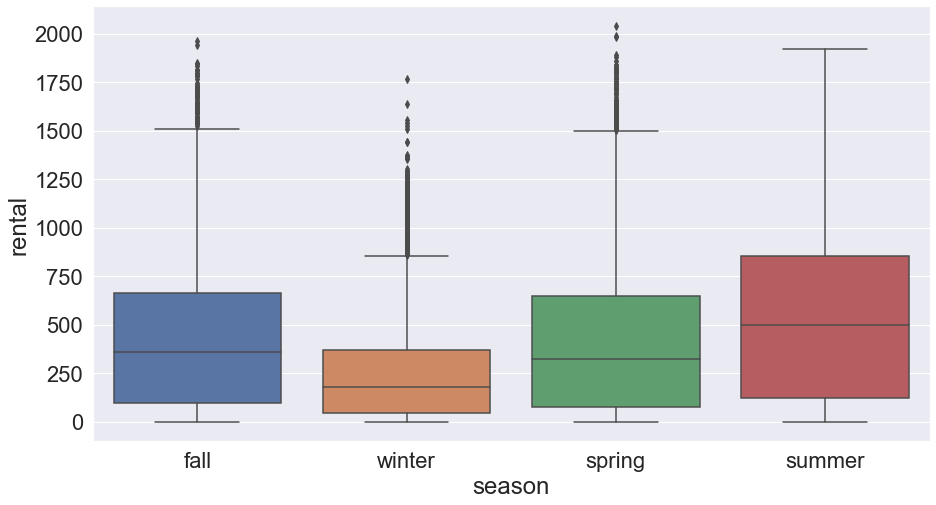

In [6]:
# To determine whether seasonality affects the total number of rentals,
# we can first use a box plot to illustrate the range of the
# number of rentals per hour for each season

sns.set(rc = {'figure.figsize': (15, 8)})
sns.set(font_scale = 2)

sns.boxplot(x="season", y="rental", data=df)
plt.show()

From this plot we can see that:
- **Winter** has the **lowest median** number of bike rentals per hour at about 200 rentals 
- **Summer** has the **highest median** number of bike rentals per hour at about 500 rentals
- **Winter** has the **smallest range** in number of bike rentals per hour, with 0 being its minimum and about 850 rentals per hour at it's maximum
- **Summer** has the **largest range** in number of bike rentals per hour, with 0 being its minimum and close to 2000 rentals per hour at it's maximum

In [12]:
# We can also group the data by season using a groupby to find the average number of bike rentals per season 
season_df = df.groupby(['season'])[['rental']].mean().reset_index().rename(columns= {'rental': 'Average Rental'})
season_df

,season,Average Rental
0,fall,448.192440
1,spring,429.512367
2,summer,546.263711
3,winter,254.418712


Text(0.5, 1.0, 'The Average Number of Bike Rentals per Hour for Each Season')

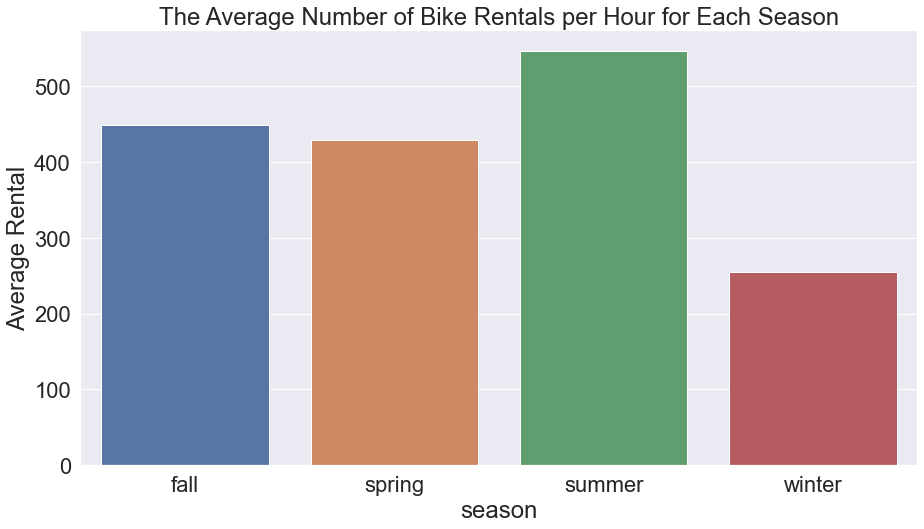

In [14]:
# Using the groupby, we can plot the average bike rentals per hour for each season using a bar graph 

ax = sns.barplot(data=season_df, x='season', y='Average Rental')
ax.set_title("The Average Number of Bike Rentals per Hour for Each Season")

From this graph we can see that:
- Summer has the **highest average** number of bike rentals per hour 
- Winter has the **lowest average** number of bike rentals per hour 
- On average, fall has **slightly more bike rentals** per hour than in spring 

From these two plots, we can see that seasonality does seem to affect the total number of rentals. On average, there are more bike rentals per hour during summer than the other seasons and less bike rentals per hour during winter than the other seasons.

 ## 2. Is there significant relationship between seasonality effect and the total number of hourly bike rentals at level of 95% confidence? (ANOVA)

In [9]:
# We can use the ANOVA test to determine if there is a significant 
# relationship between seasonality effect and the total 
# number of hourly bike rentals 
 
# create four dataframes to store the records recorded the the specified season
df_fall = df[df['season']=='fall'] # stores the records recorded in fall etc...
df_winter = df[df['season']=='winter']
df_summer = df[df['season']=='summer']
df_spring = df[df['season']=='spring']

# use the f_oneway function to do the ANOVA test
statistics, p_value = f_oneway(df_fall['rental'], 
                               df_winter['rental'], 
                               df_summer['rental'], 
                               df_spring['rental'])

print("Statistics = %.3f , p_value=%.3f" %(statistics,p_value))
if (p_value<.05):
    print('Analysis of the variance model demonstrates that the number of hourly bike rentals and seasonality effect are significantly correlated, with a p-value of %.3f'%p_value )
else:
    print('Analysis of the variance model demonstrates that the number of hourly bike rentals and seasonality effect are independent, with a p-value of %.3f'%p_value)

Statistics = 423.838 , p_value=0.000
Analysis of the variance model demonstrates that the number of hourly bike rentals and seasonality effect are significantly correlated, with a p-value of 0.000


This f-oneway functions tests the **null hypothesis that all four seasons have the same average bike rentals per hour.** The alternative hypothesis is that at **least one average number of bike rentals is different than the others.**

The ANOVA test returns two values, the **F statistic**, which is stored in the `statistics` variable, and the **P value**, which is store in the variable, `p_value`. 

The F statistic is calculated by **dividing the variation between the sample means by the variation within the samples**. In this case, we will be dividing the variation between the average number of bike rentals of each season by the variation of bike rentals within each season.

The test returned a high F statistic of 423.84, indicating that there is a **higher variation between the average bike rentals of each season than the variation of bike rentals within each season.**

To determine whether this is statistically significant, we can look at the **p-value**, which tells us **the probability of getting this result due to chance.** Our confidence level is 95%, therefore our p-value needs to be under 5% in order for this result to be statistically significant. 

Since our p_value, 0.000 < 0.05, **we can reject the null hypothesis** and conclude that **there is a significant relationship** between the seasonality effect and the total number of hourly bike rentals at a 95% confidence level. 

## 3. Does the total number of bike rentals follows Normal distribution for different season at 95% confidence level? (Normality Test)

In [10]:
# We can use the shapiro test to determine whether the total nuumber of 
# bike rentals follows Normal distribution for 
# different season at the 95% confidence level

# we can use a loop to repeat the process for each season

# create a dictionary to store the dataframes with the data by season
s_data = {'fall': df_fall, 
          'winter': df_winter, 
          'summer': df_summer, 
          'spring': df_spring}

# Loop through the dictionary to perform the shapiro test
# on each set of data (grouped by season)

for key in s_data:
    statistics, p_value = shapiro(s_data[key]['rental'])
    
    print('%s results'%(key))
    print('Statistics = %.3f, P-value=%.3f' %(statistics,p_value))
    if (p_value<.05):
        print('Test demonstrates that the number of hourly bike rentals does not follow normal distribution for the season of {}, with a p-value of {}\n'.format(key, p_value))
    else:
        print('Test demonstrates that the number of hourly bike rentals follows normal distribution for the season of {}, with a p-value of {}\n'.format(key, p_value))

fall results
Statistics = 0.895, P-value=0.000
Test demonstrates that the number of hourly bike rentals does not follows normal distribution for the season of fall, with a p-value of 0.0

winter results
Statistics = 0.834, P-value=0.000
Test demonstrates that the number of hourly bike rentals does not follows normal distribution for the season of winter, with a p-value of 0.0

summer results
Statistics = 0.933, P-value=0.000
Test demonstrates that the number of hourly bike rentals does not follows normal distribution for the season of summer, with a p-value of 1.3165479332024521e-40

spring results
Statistics = 0.884, P-value=0.000
Test demonstrates that the number of hourly bike rentals does not follows normal distribution for the season of spring, with a p-value of 0.0



The shapiro function tests **whether the data follows a normal distribution**. Since the p-value for each season's test is lower than 0.05, we **can reject the null hypthothesis** that the data follows a normal distribution. Therefore we can conclude that with 95% confidence, the total number of hourly bike rentals **does not follow a normal distribution.**

## 4. How do temperature values change over the seasons? (EDA)


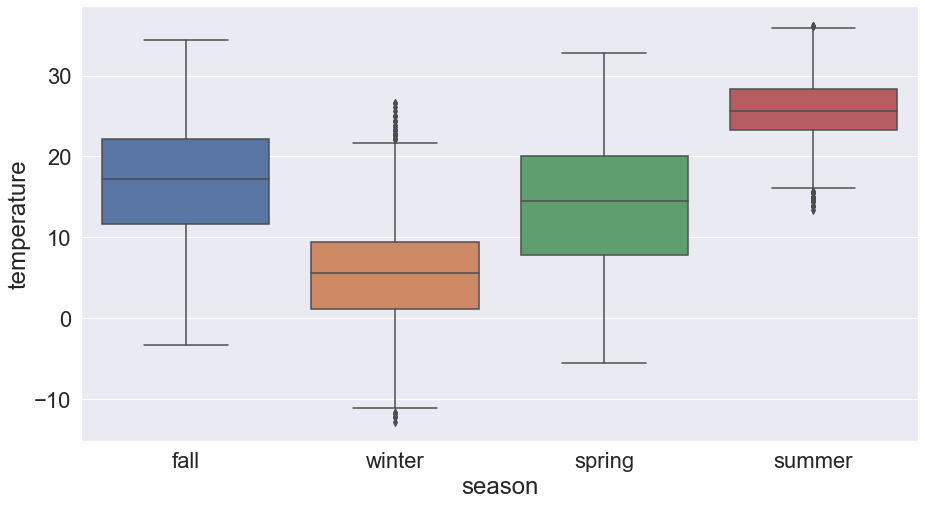

In [11]:
# we can use another box plot to 
# find the range of temperatures for each season

sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 2)

sns.boxplot(x="season",
                y="temperature",
                data=df)
plt.show()

From this plot, we can see that:
- Summer has the **highest median temperature** at about 25 degrees celsius
- Winter has the **lowest median temperature** at about 5 degrees celsius
- Summer's range of temperatures is much higher than winter's range of temperatures

In [15]:
# we can find the average temperature for each season using a groupby again
df_temp = df.groupby(['season'])['temperature'].mean().reset_index().reindex([0,3,1,2]).rename(columns={'temperature': 'Average Temperature'})
df_temp

,season,Average Temperature
0,fall,16.940525
3,winter,5.220459
1,spring,14.056739
2,summer,25.889276


Text(0.5, 1.0, 'Average Temperature During Each Season')

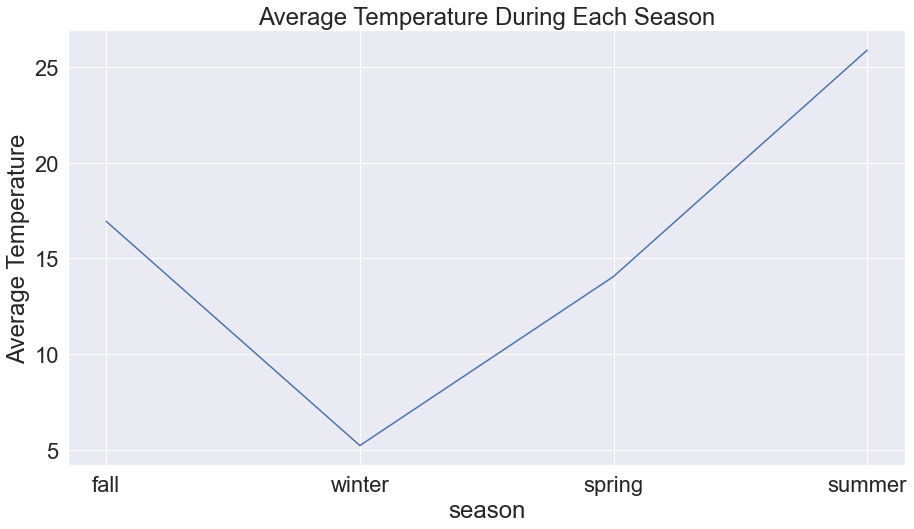

In [16]:
# Now we will plot it out using a line graph
ax = sns.lineplot(data=df_temp, x='season', y='Average Temperature')
ax.set_title("Average Temperature During Each Season")

From this line chart, we can see that:
- Summer has the **highest average temperature** at around 26 degrees celsius
- Winter has the **lowest average temperature** at around 5 degrees celsuis
- As we progress from fall to winter the average temperature drops, and as we go from winter to spring to summer, the average temperature continues to rise

## 5. Is the correlation between temperature and the number of bike rentals significant at the level of 95%? (Correlation Analysis)

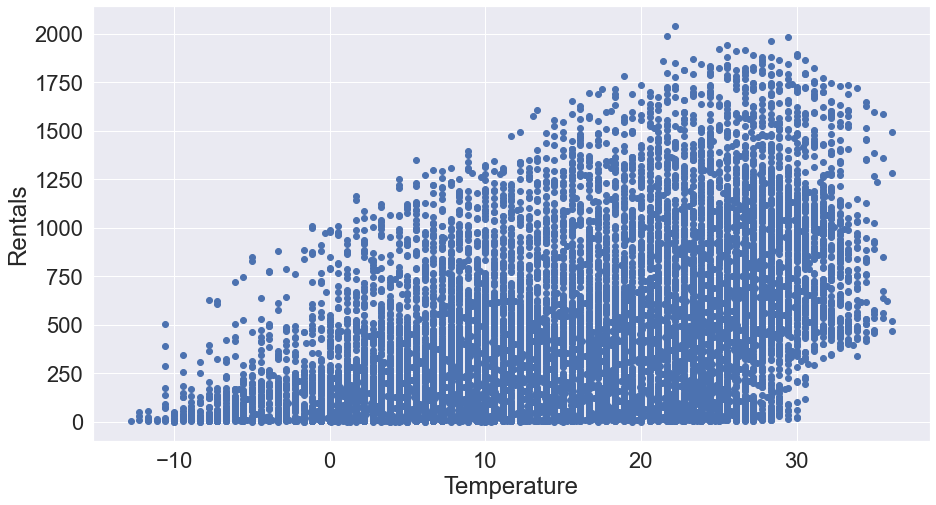

In [14]:
# First we can illustrate the relationship between temperature and the
# number of bike rentals using a scatter plot 

ax=plt.axes()
plt.scatter(df['temperature'],df['rental'])
plt.title('')
plt.xlabel('Temperature')
plt.ylabel('Rentals')
plt.show()

From this plot, we can see that there seems to be a positive correlation between temperature and the number of bike rentals. As the temperature increases, we can also see an increase in the number of bike rentals.

In [15]:
# Using the pearson test, we can determine if the 
# two variables are signifiacntly correlated 

statistic,p_value=stats.pearsonr(df['rental'], df['temperature'])
print(statistic,p_value)

if (p_value<.05):
    print('Pearson Correlation Test demonstrates that temperature and bike rentals are significantly linearly correlated, with a p-value of %.3f'%p_value )
else:
    print('Pearson Correlation Test demonstrates that temperature and bike rentals are linearly independent, with a p-value of %.3f'%p_value)

0.4363755661133611 0.0
Pearson Correlation Test demonstrates that temperature and bike rentals are significantly linearly correlated, with a p-value of 0.000


The Pearson r function **measures the correlation coefficient between two datasets**, in this case, the number of hourly bike rentals and the temperature recorded at that hour. The correlation coefficient is stored in the variable `statistic`, with possible values ranging between -1 and 1, where 1 is a positive linear relationship between the two datasets.

From this test we can see that **temperature and bike rentals are positively correlated**, as the test returned a positive correlation coefficient of 0.436. Since the p-value is less that 0.05, we **can reject the null hypothesis** and conclude that **temperature and bike rentals are significantly linearly correlated at a confidence level of 95%.**

## 6. Is there a significant difference between the total bike rental on weekends and on working days? (ANOVA)


In [16]:
# We can use the ANOVA test to see if there is a significant difference 
# between the total bike rentals on weekends and on working days 

# First create seperate dataframes for data that was collected on a weekend
# versus data that was collected on a working day
# The dummy variable, weekend, returns a 1 if the data was collected on
# a weekend

df_weekend = df[df['weekend']==1]
df_work = df[df['weekend']==0]

statistics,p_value = f_oneway(df_weekend['rental'],df_work['rental'])

print("Statistics = %.3f , p_value=%.3f" %(statistics,p_value))
if (p_value<.05):
    print('Analysis of the variance model demonstrates that the number of rentals and weekend status are significantly correlated, with a p-value of %.3f'%p_value )
else:
    print('Analysis of the variance model demonstrates that the number of rentals and weekend status are independent, with a p-value of %.3f'%p_value)

Statistics = 33.236 , p_value=0.000
Analysis of the variance model demonstrates that the number of rentals and weekend status are significantly correlated, with a p-value of 0.000


Here, the f_oneway function returns a high f statistic of 33.236, indicating that **there is a higher variation between the average number of rentals on weekends versus weekdays than the variation of bike rentals in each group.** Since the p-value, 0.000 is lower than 0.05, **we can reject the null hypothesis** and say with 95% confidence that **the number of rentals and the weekend status are significantly correlated.**

## 7. To what extend hourly demand will be affected by temperature changes? What is the main driver of  number of bike rentals? (GLM Model)

In [17]:
# Using the GLM model, we can figure out the extent 
# to which demand is affected by temperature changes

df['weekend']=df['weekend'].astype('str')

# we can start with a simple model that only includes rental, temperature and weekend status
formula = 'rental ~ temperature + weekend'
model = smf.glm(formula = formula, data = df, family=sm.families.Poisson())
result_GLM = model.fit()
print(result_GLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rental   No. Observations:                17466
Model:                            GLM   Df Residuals:                    17463
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7253e+06
Date:                Sun, 25 Sep 2022   Deviance:                   5.3266e+06
Time:                        12:35:44   Pearson chi2:                 5.32e+06
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.2384      0.001   5616.679   

In [18]:
# Check the accuracy of the model 
df['y_hat_GLM']=result_GLM.predict()
df['error'] = abs((df['rental']-df['y_hat_GLM']) / df['rental'])
MAPE = np.mean(df['error'][np.isfinite(df['error'])])
print(MAPE)
print('Mean Absoulute Error(MAPE): %.3f'%MAPE)

7.070188265199425
Mean Absoulute Error(MAPE): 7.070


From this first model, we can see that:
- By **increasing the temperature by 1 degree celsius**, the number of **bike rentals per hour will increase by about 4.75%** (exp(0.0464) = 2.04749) assuming all other variables are constant 
- **Weekends result in a 6.11% decrease** (exp(-0.0630) = 0.9389) in bike rentals per hour **in comparison to weekdays**
    - this could imply that there may be a number of people that rent bikes to go to work, which could explain why there are more rentals on weekdays rather than weekends (although this is just an assumption)

- Since the p-values are less than 0.05, we can say that weekend status and temperature are a significant predictor of bike rentals per hour 

In [74]:
# Now we can try adding in more variables to improve the model 
formula = 'rental ~  year + hour + temperature + weekend + season + precip + windspeed + pressure + humidity'
model = smf.glm(formula = formula, data = df, family=sm.families.Poisson())
result_GLM = model.fit()
print(result_GLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rental   No. Observations:                17466
Model:                            GLM   Df Residuals:                    17454
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1565e+06
Date:                Sun, 25 Sep 2022   Deviance:                   4.1890e+06
Time:                        13:35:36   Pearson chi2:                 4.77e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           39.1260      1.292  

In [75]:
# Check the accuracy of the model 
df['y_hat_GLM']=result_GLM.predict()
df['error'] = abs((df['rental']-df['y_hat_GLM']) / df['rental'])
MAPE = np.mean(df['error'][np.isfinite(df['error'])])
print(MAPE)
print('Mean Absoulute Error(MAPE): %.3f'%MAPE)

4.540759532474086
Mean Absoulute Error(MAPE): 4.541


By not including all variables, we were able to get an improved model performance due to the increase in the log-likelyhood. 

From this model, we can see that:
- By **increasing the precipitation by one mm will result in a 92.15% decrease** (exp(-2.5451) = 0.07847) in bike rentals per hour 
- **Seasons other than fall will result in a lower number of bike rentals per hour than Fall** since the coefficients for the variables are all negative
    - For instance, spring will result in a 3.56% decrease (exp(-0.0362) = 0.9644) in bike rentals than those recorded in the fall
    - this could be due to the fact that there is more precipitation seen in seasons like spring and summer than in fall
- A **1 year increase results in a 1.79% decrease** (exp(-0.0181 = 0.9821) in bike rentals per hour 

In [81]:
# we can also add a final model that excludes the 
# season variable, as it seems to be significantly correlated with many of the other 
# independent variables 
# Now we can try adding in more variables to improve the model 
formula = 'rental ~  year + hour + temperature + weekend + precip + windspeed + pressure + humidity'
model = smf.glm(formula = formula, data = df, family=sm.families.Poisson())
result_GLM = model.fit()
print(result_GLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rental   No. Observations:                17466
Model:                            GLM   Df Residuals:                    17457
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1831e+06
Date:                Sun, 25 Sep 2022   Deviance:                   4.2422e+06
Time:                        14:30:15   Pearson chi2:                 4.82e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       91.0905      1.193     76.385   

In [83]:
# Check the accuracy of the model 
df['y_hat_GLM']=result_GLM.predict()
df['error'] = abs((df['rental']-df['y_hat_GLM']) / df['rental'])
MAPE = np.mean(df['error'][np.isfinite(df['error'])])
print(MAPE)
print('Mean Absoulute Error(MAPE): %.3f'%MAPE)

4.590075658854875
Mean Absoulute Error(MAPE): 4.590


From this model we can see that (while holding all other variables constant):
- An increase in 1 degrees celsius will result to a 4.48% increase in bike rentals per hour 
- Weekends result in a 6.18% decrease in bike rentals compared to weekdays
- A 1 year increase will result to a 4.32% decrease in bike rentals
- A 1 mm increase in precpitation will result in a 93.04% decrease in bike rentals
- An increase in pressure will result in an increase in bike rentals while a increase in humidity will reusult in a slight decrease in bike rentals 

Therefore, temperature changes will have a slight effect on the hourly bike rentals, as an increase in temperature by 1 degree will result in a 4.48% increase in bike rentals. According to the model above, **the main driver of bike rentals per hour is the level of precipitation recorded at that hour**, as a 1 mm increase in precipitation results in a 93.04% decrease in bike rentals for that hour. 

## 8. What is your suggestions and recommendations to enhance the effectiveness of bike rental business ?

From the analysis above, I would suggest that:
- they should maintain a **higher supply of rental bikes** and stations in locations that have **higher temperatures and lower precipitation** 
- they should also make sure that there is a **higher supply of bikes during fall in comparison to other seasons**
- they can reduce the number of rental bikes during winter in comparison to other seasons 
- since we can see a 1.79% decrease in bike rentals as we increase the year, I suggest that the business **should not implement a large amount of new bike stations, as this may result in an excess supply of rental bikes in the future**

#### References

1. Scipy.stats.f_oneway. scipy.stats.f_oneway - SciPy v1.9.1 Manual. (n.d.). Retrieved September 24, 2022, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html 

2. Scipy.stats.pearsonr. scipy.stats.pearsonr - SciPy v1.9.1 Manual. (n.d.). Retrieved September 24, 2022, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html 

3. Scipy.stats.shapiro. scipy.stats.shapiro - SciPy v1.9.1 Manual. (n.d.). Retrieved September 25, 2022, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html 

4. Zach. (2021, May 11). What does a high F value mean in ANOVA? Statology. Retrieved September 24, 2022, from https://www.statology.org/what-does-a-high-f-value-mean/#:~:text=The%20F%2Dvalue%20in%20an%20ANOVA%20is%20calculated%20as%3A%20variation,lower%20the%20corresponding%20p%2Dvalue 